Year                  0
Month                 0
Day                   1
Hour                  0
Minute                0
Temperature           0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Dew Point             0
DHI                   0
DNI                   0
Fill Flag             0
GHI                   0
Ozone                 0
Relative Humidity     0
Solar Zenith Angle    0
Surface Albedo        0
Pressure              0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
POA                   0
Power generated       0
dtype: int64
Epoch 1/100


/Users/kartikparasher/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 181.7317 - mae: 8.4605 - mse: 180.5354 - val_loss: 167.1852 - val_mae: 7.9722 - val_mse: 166.1586 - learning_rate: 5.0000e-04
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 142.7489 - mae: 7.8191 - mse: 141.7482 - val_loss: 90.3955 - val_mae: 5.5438 - val_mse: 89.4436 - learning_rate: 5.0000e-04
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 84.4222 - mae: 6.2317 - mse: 83.4769 - val_loss: 18.5430 - val_mae: 2.4139 - val_mse: 17.6092 - learning_rate: 5.0000e-04
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 40.7367 - mae: 4.4413 - mse: 39.8044 - val_loss: 5.5611 - val_mae: 1.3113 - val_mse: 4.6352 - learning_rate: 5.0000e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 33.4729 - mae: 3.9908 - mse: 32.5494 - val_loss: 3.9979 - val_mae: 1.1025 - val_mse: 3.0844 - learning_rate: 5.0000e-04
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 31.9737 - mae: 3.8841 - 

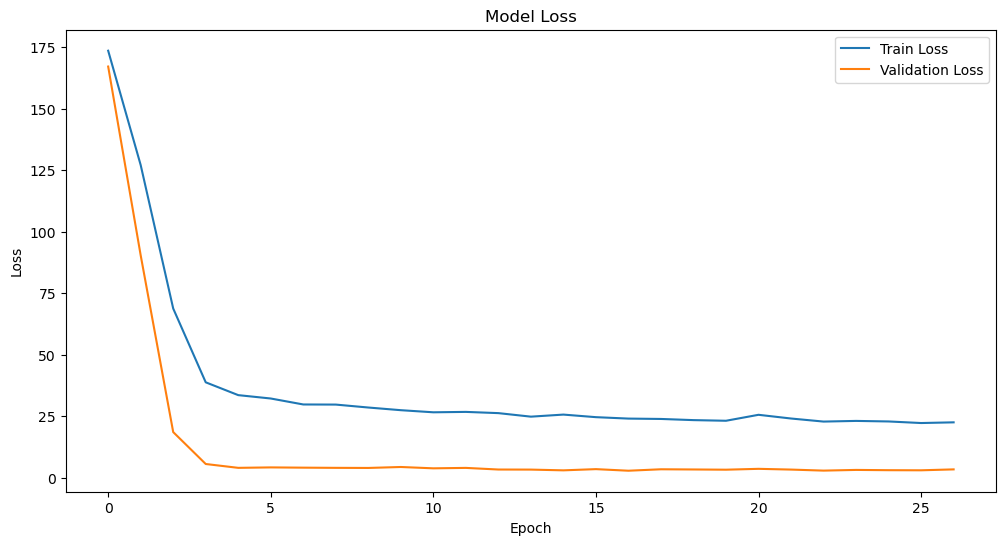

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Power Generated (LSTM): 29.85460090637207


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GaussianNoise, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

# Load the dataset
data = pd.read_csv('solar_data_new.csv')

# Check for missing values
print(data.isnull().sum())

# Separate features and target variable
features = data.drop(columns=['Power generated'])
target = data['Power generated']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Reshape features for LSTM input (samples, time steps, features)
features_reshaped = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_reshaped, target, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    GaussianNoise(0.1, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(20, activation='relu', return_sequences=True, kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)),
    Dropout(0.5),
    BatchNormalization(),
    LSTM(10, activation='relu', kernel_regularizer=l2(0.02), kernel_constraint=MaxNorm(3)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(5, activation='relu'),
    Dense(1)  # Output layer, no activation function for regression
])

# Compile the model
optimizer = Nadam(learning_rate=0.0005, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
mse_lstm, _, mae_lstm = model.evaluate(X_test, y_test, verbose=0)
r2_lstm = r2_score(y_test, model.predict(X_test))

print(f'Mean Squared Error (LSTM): {mse_lstm}')
print(f'R^2 Score (LSTM): {r2_lstm}')

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Sample new input
new_input = {
    'Year': 2016,
    'Month': 1,
    'Day': 1,
    'Hour': 12,
    'Minute': 30,
    'Temperature': 28.1,
    'Clearsky DHI': 153,
    'Clearsky DNI': 833,
    'Clearsky GHI': 810,
    'Cloud Type': 0,
    'Dew Point': 22,
    'DHI': 153,
    'DNI': 833,
    'Fill Flag': 0,
    'GHI': 810,
    'Ozone': 0.223,
    'Relative Humidity': 69.33,
    'Solar Zenith Angle': 37.89,
    'Surface Albedo': 0.08,
    'Pressure': 1010,
    'Precipitable Water': 2.8,
    'Wind Direction': 55,
    'Wind Speed': 3.5,
    'POA': 904.03
}

# Convert new input to DataFrame
new_input_df = pd.DataFrame([new_input])

# Impute missing values in new input
new_input_imputed = imputer.transform(new_input_df)

# Normalize the new input
new_input_scaled = scaler.transform(new_input_imputed)

# Reshape for LSTM input
new_input_reshaped = new_input_scaled.reshape(1, 1, new_input_scaled.shape[1])

# Predict with the LSTM model
new_prediction_lstm = model.predict(new_input_reshaped)
print(f'Predicted Power Generated (LSTM): {new_prediction_lstm[0][0]}')


In [ ]:
Year	Month	Day	Hour	Minute	Temperature	Clearsky DHI	Clearsky DNI	Clearsky GHI	Cloud Type	Dew Point	DHI	DNI	Fill Flag	GHI	Ozone	Relative Humidity	Solar Zenith Angle	Surface Albedo	Pressure	Precipitable Water	Wind Direction	Wind Speed		POA	Power generated
2017	1		0	30	23.5	0	0	0	0	21	0	0	0	0	0.24	85.94	164.66	0.11	1012	2.6	45	3.7		0	0
2017	1	1	1	30	23.4	0	0	0	0	20.9	0	0	33	0	0.241	85.65	152.46	0.11	1011	2.6	45	3.7		0	0
2017	1	1	2	30	23.3	0	0	0	3	20.7	0	0	0	0	0.242	85.45	138.98	0.11	1011	2.7	46	3.6		0	0
2017	1	1	3	30	23.2	0	0	0	3	20.6	0	0	0	0	0.242	85.23	125.22	0.11	1011	2.7	48	3.4		0	0
2017	1	1	4	30	23.2	0	0	0	3	20.5	0	0	0	0	0.242	84.81	111.43	0.11	1011	2.7	48	3.3		0	0
2017	1	1	5	30	22.7	0	0	0	3	20.3	0	0	0	0	0.249	86.59	97.76	0.13	1014	2.8	18	3.3		0	0
2017	1	1	6	30	23.5	39	241	63	0	20.4	37	153	50	52	0.25	83.02	84.19	0.13	1015	2.8	18	3.6		52.912120837261	2.22681341417731
2017	1	1	7	30	25	80	619	279	3	20.5	122	141	75	167	0.25	76.31	71.29	0.13	1015	2.8	26	3.9		163.513626835254	6.74455855212353
2017	1	1	8	30	26.3	94	793	502	3	20.9	172	397	0	376	0.25	72.14	59.06	0.13	1016	2.8	36	4.2		383.272573013664	15.2717786580764
2017	1	1	9	30	27.2	96	887	688	0	20.9	96	887	0	688	0.25	68.37	48.17	0.13	1015	2.8	40	4.4		738.54942183998	27.8925155074805
2017	1	1	10	30	27.7	103	922	812	0	20.8	103	922	0	812	0.249	65.94	39.78	0.13	1014	2.8	42	4.5		881.665251839833	32.5402009103349
2017	1	1	11	30	28.1	117	917	862	0	20.7	117	917	0	862	0.248	64.12	35.7	0.13	1013	2.8	44	4.6		947.572927364945	34.5727910110948
2017	1	1	12	30	28.2	112	919	842	0	20.6	112	919	0	842	0.247	63.51	37.39	0.13	1012	2.8	46	4.6		944.699804734911	34.4680457137786
2017	1	1	13	30	28.1	114	878	744	0	20.6	114	878	0	744	0.247	63.74	44.18	0.13	1011	2.8	46	4.8		854.320005966286	31.6051575792754
2017	1	1	14	30	27.7	118	785	577	0	20.5	118	785	0	577	0.247	64.91	54.18	0.13	1011	2.8	46	4.9		684.268354578264	25.9918513605858
2017	1	1	15	30	27.1	95	680	372	0	20.4	95	680	0	372	0.246	66.92	65.94	0.13	1011	2.8	46	4.9		470.205041501027	18.4539501982604
2017	1	1	16	30	26	60	449	149	0	20.6	60	449	0	149	0.246	72.05	78.62	0.13	1012	2.7	45	4.4		214.285526423704	8.74599905121205

In [ ]:
2017	1	1	10	30	27.7	103	922	812	0	20.8	103	922	0	812	0.249	65.94	39.78	0.13	1014	2.8	42	4.5		881.665251839833

In [30]:
E = 2.22
hydrogen_mass = (E)/53
print(hydrogen_mass)

0.04188679245283019
